# Рекомендация тарифов

**Описание проекта**

Оператор мобильной связи «Мегалайн» хочет предложить клиентам, использующим архивные тарифы, наиболее подходящий новый тариф. Есть данные о поведении клиентов, уже перешедших на новые тарифы.

Путь к данным: /datasets/users_behavior.csv

**Цель исследования**

Построить модель для задачи классификации, которая выберет подходящий тариф («Смарт» или «Ультра»).

## Откройте и изучите файл

In [2]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [3]:
# чтение файлов с данными и сохранение
df = pd.read_csv('/datasets/users_behavior.csv')

In [4]:
# получение первых строк
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [5]:
# получение общей информации
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Общая информация**

В таблице 3214 строк и 5 столбцов. Описания столбцов, согласно документации:

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**Вывод**

Колонка `is_ultra` — целевой признак. Остальные колонки являются признаками, по которым будет предсказываться целевой.

## Разбейте данные на выборки

Выделим целовой признак и остальные в отдельные группы

In [6]:
с
features = df.drop(['is_ultra'], axis=1) 
# целевой признак
target = df['is_ultra'] 

Разобьем все данные на три выборки: сначала выделим обучающую (60%), а остальные данные на равные выборкии валидационную и тестовую.

In [7]:
# выделение обучающей выборки
features_train, features_other, target_train, target_other = train_test_split(
    features, target, test_size=0.4, random_state=12345)
# разбиение оставшихся данных на валидационную и тестувую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_other, target_other, test_size=0.5, random_state=12345)

Проверим размеры получившихся выборок

In [8]:
print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (1928, 4)
Размер валидационной выборки: (643, 4)
Размер тестовой выборки: (643, 4)


## Исследуйте модели

In [9]:
list_accuracy = []

В список будем заносить параметры лучших моделей для сравнения

### Дерево

In [10]:
tree = pd.DataFrame([], columns=['depth','accuracy'])

Будем меняться максимальную глубину дерева модели. Для каждого дерева вычислим accuracy и среди всех выберем самую удачную модель.

In [11]:
best_model_tree = None
best_result_tree = 0
for depth in range(1, 11):
    # создение модели
    model1 = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    # обучение 
    model1.fit(features_train, target_train)
    # предсказания на валидационной выборке
    predictions_valid = model1.predict(features_valid)
    # доля правильных ответов
    accuracy = accuracy_score(target_valid, predictions_valid)
    tree.loc[len(tree.index)] = [depth, accuracy]
    # определение лучшей модели
    if accuracy > best_result_tree:
        best_model_tree = model1
        best_result_tree = accuracy

In [12]:
list_accuracy.append(['best_model_tree', best_result_tree, best_model_tree.score(features_train, target_train)])

Гиперпараметры дерева с лучшим accuracy:

In [13]:
best_model_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

Для наглядности приведем график зависимости доли правильных предсказаний модели от изменения параметров

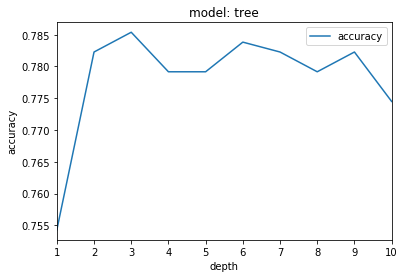

In [14]:
tree.plot(x='depth', y='accuracy')
plt.title('model: tree')
plt.ylabel('accuracy')
plt.show()

Из графика видно, что максимальная доля правильных ответов достигается при максимальной глубине дерева равной трем, далее accuracy падает

### Лес

In [15]:
forest = pd.DataFrame([], columns=['n_estimators', 'depth', 'accuracy'])

Будем меняться максимальную число деревьев и их максимальную глубину. Для каждого случая вычислим accuracy и среди всех выберем самую удачную модель.

In [16]:
best_model_forest = None
best_result_forest = 0
for n in range(1, 11):
    for depth in range (1, 11):
        # создение модели с заданными гиперпараметрами
        model2 = RandomForestClassifier(random_state=12345, n_estimators=n, max_depth=depth) 
        # обучение 
        model2.fit(features_train, target_train)
        # предсказания на валидационной выборке
        predictions_valid = model2.predict(features_valid)
        # доля правильных ответов
        accuracy = accuracy_score(target_valid, predictions_valid)
        forest.loc[len(forest.index)] = [n, depth, accuracy]
        # определение лучшей модели
        if accuracy > best_result_forest:
            best_model_forest = model2
            best_result_forest = accuracy

In [17]:
list_accuracy.append(['best_model_forest', best_result_forest, best_model_forest.score(features_train, target_train)])

Гиперпараметры леса с лучшим accuracy:

In [18]:
best_model_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=8,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

График зависимости accuracy от изменения максимальной глубины деревьев для фиксированного числа деревьев

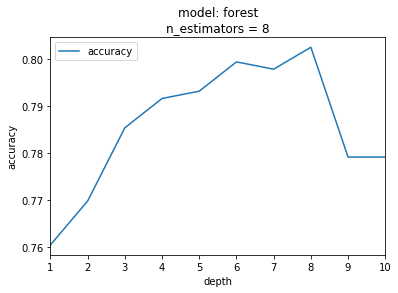

In [19]:
forest.query('n_estimators == 8').plot(x='depth', y='accuracy', legend=True)
plt.title('model: forest\nn_estimators = 8')
plt.ylabel('accuracy')
plt.show()

График зависимости accuracy от изменения  числа деревьев для фиксированной максимальной глубины деревьев

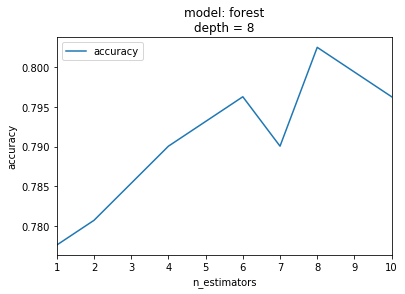

In [20]:
forest.query('depth == 8').plot(x='n_estimators', y='accuracy', legend=True)
plt.title('model: forest\ndepth = 8')
plt.ylabel('accuracy')
plt.show()

### Логистическая регрессия

У логистической реграссии нет столько параметров. Рассмотрим модель со стандартными параметрами

In [21]:
# создение модели
logreg = LogisticRegression(random_state=12345)
# обучение 
logreg.fit(features_train, target_train) 
# предсказания на валидационной выборке
predictions_valid = logreg.predict(features_valid)
best_result_logreg = logreg.score(features_valid, target_valid)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [22]:
list_accuracy.append(['logreg', best_result_logreg, logreg.score(features_train, target_train)])

In [23]:
logreg.score(features_train, target_train)

0.7505186721991701

**Вывод**

Сравним accuracy (на валидационной и обучающей выборках) для всех моделей с выбранными наилучшими гиперпараметрами.

In [24]:
df_accuracy = pd.DataFrame(list_accuracy, columns =['model', 'accuracy: valid', 'accuracy: train'])
df_accuracy

,model,accuracy: valid,accuracy: train
0,best_model_tree,0.785381,0.807573
1,best_model_forest,0.802488,0.868257
2,logreg,0.758942,0.750519


Лучшие результаты на валидационной выборке показывает случайный лес (модель с n_estimators=8, max_depth=8), она же менее быстродейственная. В данном случае она в принципе работает с достаточной скоростью, поэтому выберем ее

## Проверьте модель на тестовой выборке

In [25]:
# предсказания на тестовой выборке
predictions = best_model_forest.predict(features_test)
accuracy = accuracy_score(target_test, predictions)

In [26]:
accuracy 

0.7962674961119751

Доля правильных ответов примерно та же, что и для валидационной выборки. 


## Общий вывод

Была построена модель для задачи классификации, которая выбирает подходящий пользователю тариф («Смарт» или «Ультра»). Модель представляет собой случайный лес с гиперпараметрами n_estimators=8, max_depth=8. 

1. Для этого были загружены данные, предоставленные оператором. 
2. Данные были рабиты на три части: обучающую, валидационную и и тренировочную выборки. 
3. Проведено исседование трех моделей: дерева решений, случайного леса и логистической регрессии. Для дерева решений изменялась максимальная глубина дерева (от 1 до 10). Для леса - число деревьев (от 1 до 10) и максимальная глубина деревьев (от 1 до 10). Для каждой модели посчитана доля правильных ответов и выделены модели, выдающие лучший результат

In [28]:
df_accuracy

,model,accuracy: valid,accuracy: train
0,best_model_tree,0.785381,0.807573
1,best_model_forest,0.802488,0.868257
2,logreg,0.758942,0.750519


4. Была выбрана оптимальная модель.
5. Модель проверена на тестовой выборке, accuracy на тестовой выборке составляет около 0,79. 